**Passos iniciais**

In [1567]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix

In [1568]:
data = pd.read_csv('heart-disease.csv')

**Pré-Processamento dos dados**

In [1569]:
attributesName = data.columns[:-1]

Verificando Duplicatas e Amostras inconsistentes

In [1570]:
#Criando um dataframe com os registros duplicados em todas as colunas, menos a ultima. 
df_duplicates = data[data.duplicated(subset=attributesName, keep=False)]

if len(df_duplicates) > 0:
    print('\nAmostras redundantes ou inconsistentes:')
    display(df_duplicates)
else:
    print('Não existem valores duplicados')


Amostras redundantes ou inconsistentes:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


Caso exista, removê-los

In [1571]:
data = data.drop_duplicates(keep='first')

Verificar se as amostras foram removidas

In [1572]:
#Criando um dataframe com os registros duplicados em todas as colunas, menos a ultima. 
df_duplicates = data[data.duplicated(subset=attributesName, keep=False)]

if len(df_duplicates) > 0:
    print('\nAmostras redundantes ou inconsistentes:')
    display(df_duplicates)
else:
    print('Não existem valores duplicados')

Não existem valores duplicados


**Estatística dos Dados**

In [1573]:
dataInfo = data.describe()
display(dataInfo)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Normalizando os dados

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


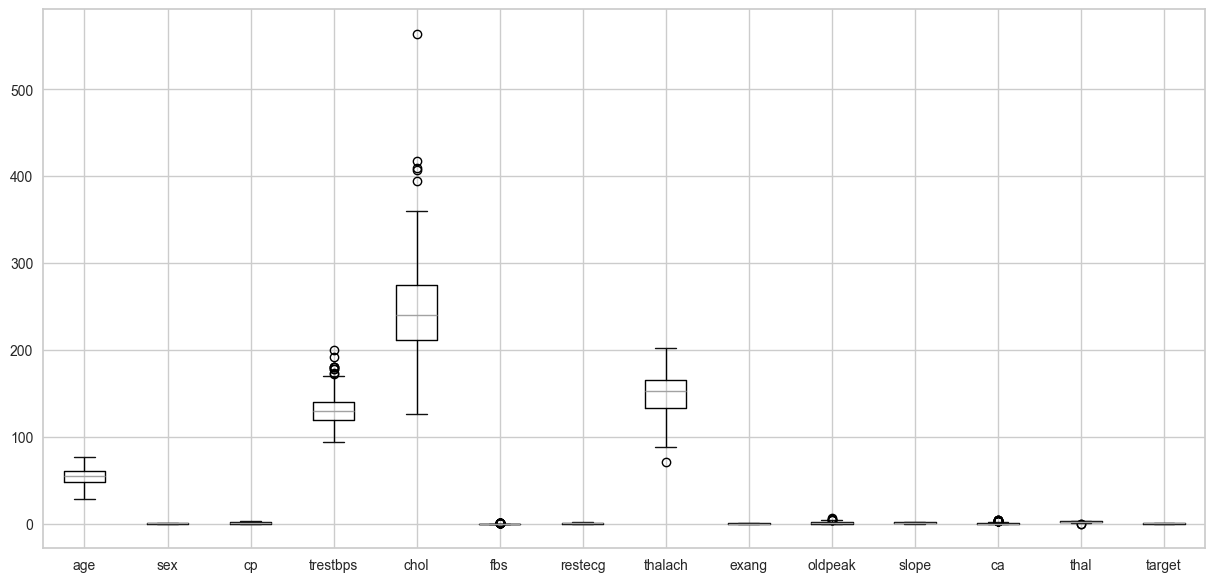

In [1574]:
from sklearn.preprocessing import MinMaxScaler

def normaliza(df):
    # Inicializa o MinMaxScaler
    scaler = MinMaxScaler()

    # Seleciona todas as colunas, exceto a última (target class)
    normalizeColumns = df.iloc[:, :-1]

    # Ajusta e transforma os dados com o MinMaxScaler
    df_normalized = pd.DataFrame(scaler.fit_transform(normalizeColumns), columns=normalizeColumns.columns)

    # Adiciona a última coluna não normalizada ao DataFrame normalizado
    df_normalized[df.columns[-1]] = df[df.columns[-1]].values  # Usar .values para garantir a compatibilidade

    return df_normalized

# data = normaliza(data)

# Verificar se há NaNs na target class após a normalização
print(data.isnull().sum())

# Gera um boxplot para cada atributo
data.boxplot(figsize=(15,7))
plt.show()


In [1575]:
Class = data.columns[-1]
np.unique(data[Class], return_counts=True)

(array([0, 1]), array([138, 164]))

Removendo Outliers

In [1576]:
dataInfo = data.describe()

# Inicializa um DataFrame limpo
data_clean = data.copy()

outliers_removed = pd.DataFrame()

# Para todas as colunas numéricas
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_cols:
    Q1 = dataInfo[col]['25%']
    Q3 = dataInfo[col]['75%']
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    

    # Identificando os outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    
    # Armazenando os outliers removidos
    outliers_removed = pd.concat([outliers_removed, outliers])

    # Filtrando os dados para remover outliers
    data_clean = data_clean[(data_clean[col] >= lower_bound) & (data_clean[col] <= upper_bound)]


display(data_clean)

print('\n Os outliers removidos: ')
display(outliers_removed)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,63,0,0,124,197,0,1,136,1,0.0,1,0,2,0
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0



 Os outliers removidos: 


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
101,59,1,3,178,270,0,0,145,0,4.2,0,0,3,1
110,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1
203,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0
223,56,0,0,200,288,1,0,133,1,4.0,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,45,1,0,142,309,0,0,147,1,0.0,1,3,3,0
267,49,1,2,118,149,0,0,126,0,0.8,2,3,2,0
291,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
48,53,0,2,128,216,0,0,115,0,0.0,2,0,0,1


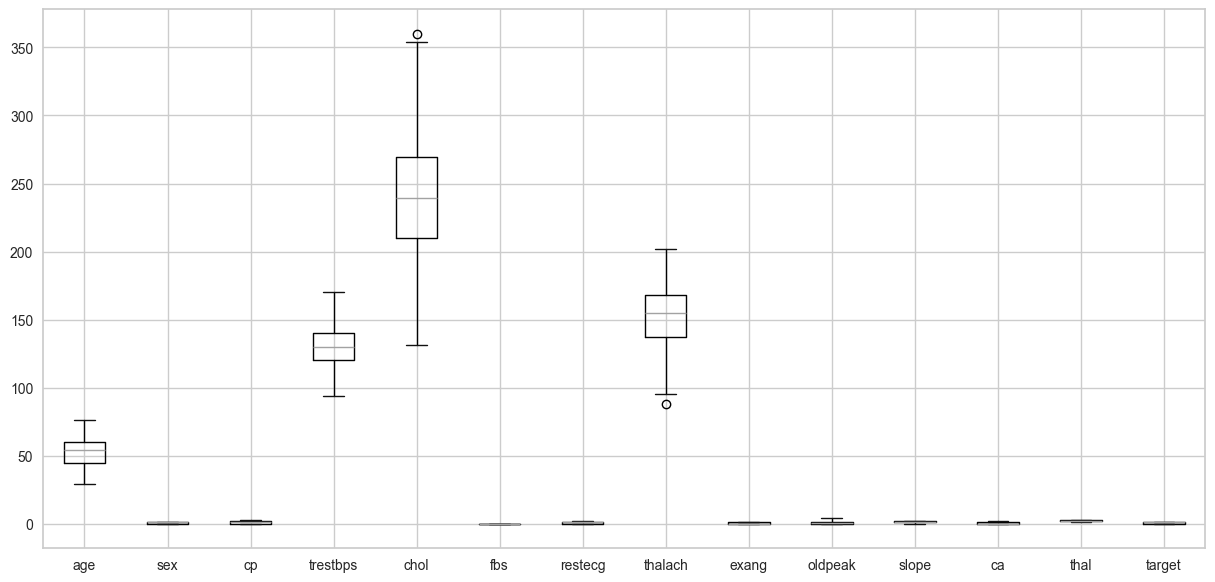

In [1577]:
data_clean.boxplot(figsize=(15, 7))
plt.show()

Inputando dados usando o KNN para correção de outliers

In [1578]:
from sklearn.impute import KNNImputer

dataInfo = data.describe()

# Inicializa um DataFrame limpo
data_knn = data.copy()


outliers_removed = pd.DataFrame()

# Para todas as colunas numéricas
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Inicializa o KNNImputer
imputer = KNNImputer(n_neighbors=5)  

for col in numerical_cols:
    Q1 = dataInfo[col]['25%']
    Q3 = dataInfo[col]['75%']
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificando os outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    
    # Armazenando os outliers removidos
    outliers_removed = pd.concat([outliers_removed, outliers])
    
    # Criar uma cópia da coluna original para imputação
    temp_column = data_knn[col].copy()
    
    # Imputar valores nos outliers
    outlier_indices = temp_column[(temp_column < lower_bound) | (temp_column > upper_bound)].index
    temp_column[outlier_indices] = None  # Definir outliers como None para imputação
    
    # Ajustar a coluna com imputação KNN
    temp_column_imputed = imputer.fit_transform(temp_column.values.reshape(-1, 1))
    
    # Atualizar a coluna no DataFrame limpo
    data_knn[col] = temp_column_imputed

display(data_knn)
display(outliers_removed)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,3.0,145.0,233.0,0.0,0.0,150.0,0.0,2.3,0.0,0.0,1.0,1.0
1,37.0,1.0,2.0,130.0,250.0,0.0,1.0,187.0,0.0,3.5,0.0,0.0,2.0,1.0
2,41.0,0.0,1.0,130.0,204.0,0.0,0.0,172.0,0.0,1.4,2.0,0.0,2.0,1.0
3,56.0,1.0,1.0,120.0,236.0,0.0,1.0,178.0,0.0,0.8,2.0,0.0,2.0,1.0
4,57.0,0.0,0.0,120.0,354.0,0.0,1.0,163.0,1.0,0.6,2.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57.0,0.0,0.0,140.0,241.0,0.0,1.0,123.0,1.0,0.2,1.0,0.0,3.0,0.0
299,45.0,1.0,3.0,110.0,264.0,0.0,1.0,132.0,0.0,1.2,1.0,0.0,3.0,0.0
300,68.0,1.0,0.0,144.0,193.0,0.0,1.0,141.0,0.0,3.4,1.0,2.0,3.0,0.0
301,57.0,1.0,0.0,130.0,131.0,0.0,1.0,115.0,1.0,1.2,1.0,1.0,3.0,0.0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
101,59,1,3,178,270,0,0,145,0,4.2,0,0,3,1
110,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1
203,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0
223,56,0,0,200,288,1,0,133,1,4.0,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,45,1,0,142,309,0,0,147,1,0.0,1,3,3,0
267,49,1,2,118,149,0,0,126,0,0.8,2,3,2,0
291,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
48,53,0,2,128,216,0,0,115,0,0.0,2,0,0,1


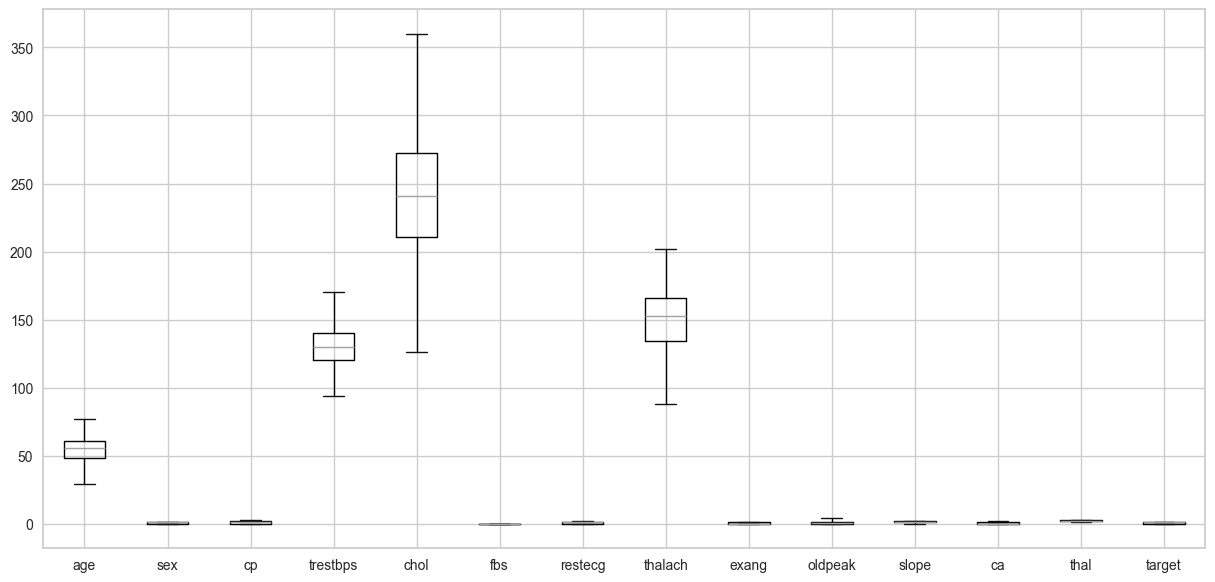

In [1579]:
data_knn.boxplot(figsize=(15, 7))
plt.show()

**Separação de Amostras**

In [1580]:
Class_Clean = data_clean.columns[-1]
np.unique(data[Class_Clean], return_counts=True)

Class_KNN = data_knn.columns[-1]
np.unique(data[Class_KNN], return_counts=True)

(array([0, 1]), array([138, 164]))

In [1581]:
sns.countplot(x = data_clean[Class_Clean])
sns.countplot(x = data_knn[Class_Clean])

<Axes: xlabel='target', ylabel='count'>

**Separando os atributos de entrada e de classe**

In [1582]:
x_prev_clean = data_clean.iloc[:, :-1]
print(x_prev_clean)

x_prev_knn = data_knn.iloc[:, :-1]
print(x_prev_knn)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
5     57    1   0       140   192    0        1      148      0      0.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
296   63    0   0       124   197    0        1      136      1      0.0   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  
1        0   0     2  
2        2   0     2  
3        2   0    

In [1583]:
y_prev_clean = data_clean.iloc[:,-1]
print(y_prev_clean)

y_prev_knn = data_knn.iloc[:,1]
print(y_prev_knn)

1      1
2      1
3      1
4      1
5      1
      ..
296    0
298    0
299    0
301    0
302    0
Name: target, Length: 228, dtype: int64
0      1.0
1      1.0
2      0.0
3      1.0
4      0.0
      ... 
298    0.0
299    1.0
300    1.0
301    1.0
302    0.0
Name: sex, Length: 302, dtype: float64


**Separação de dados**

In [1584]:
print(x_prev_clean.shape)
print(x_prev_knn.shape)

(228, 13)
(302, 13)


In [1585]:
print(y_prev_clean.shape)
print(y_prev_knn.shape)

(228,)
(302,)


In [1586]:
from sklearn.model_selection import train_test_split
#colocando random state em 0 para testes mais consistentes
x_treino_knn, x_teste_knn, y_treino_knn, y_teste_knn = train_test_split(x_prev_knn, y_prev_knn, test_size = 0.20, random_state = 0)

x_treino_clean, x_teste_clean, y_treino_clean, y_teste_clean = train_test_split(x_prev_clean, y_prev_clean, test_size = 0.20, random_state = 0)

**Area de treino dos modelos**

*Naive Bayes*

DataSet com os outliers removidos

In [1587]:
from sklearn.naive_bayes import GaussianNB
modelo = GaussianNB()
modelo.fit(x_treino_clean, y_treino_clean)
previsoes = modelo.predict(x_teste_clean)

In [1588]:
confusion_matrix(y_teste_clean, previsoes)

array([[21,  3],
       [ 7, 15]])

In [1589]:
print(classification_report(y_teste_clean, previsoes))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        24
           1       0.83      0.68      0.75        22

    accuracy                           0.78        46
   macro avg       0.79      0.78      0.78        46
weighted avg       0.79      0.78      0.78        46



DataSet com KNN

In [1590]:
from sklearn.naive_bayes import GaussianNB
modelo = GaussianNB()
modelo.fit(x_treino_knn, y_treino_knn)
previsoes = modelo.predict(x_teste_knn)

In [1591]:
confusion_matrix(y_teste_knn, previsoes)

array([[16,  0],
       [ 0, 45]])

In [1592]:
print(classification_report(y_teste_knn, previsoes))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00        45

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



**Decision Tree**

DataSet com os Outliers removidos

In [1593]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {
    'criterion':  ['gini', 'entropy', 'log_loss'],
    'splitter': ['random'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
}

modelo = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=params,
    cv=10,
    n_jobs=5,
    verbose=1,
)



In [1594]:
modelo.fit(x_treino_clean, y_treino_clean)
print(modelo.best_params_)
print(modelo.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'splitter': 'random', 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}
0.8070175438596492


In [1595]:
X = data_clean.drop('target', axis=1)  # Features
y = data_clean['target']                # Target

In [1596]:
modelo= DecisionTreeClassifier(**modelo.best_params_)
modelo.fit(x_treino_clean, y_treino_clean)

DecisionTreeClassifier(criterion='entropy', splitter='random')

In [1597]:
previsoes = modelo.predict(x_teste_clean)
accuracy_score(y_teste_clean,previsoes)

0.782608695652174

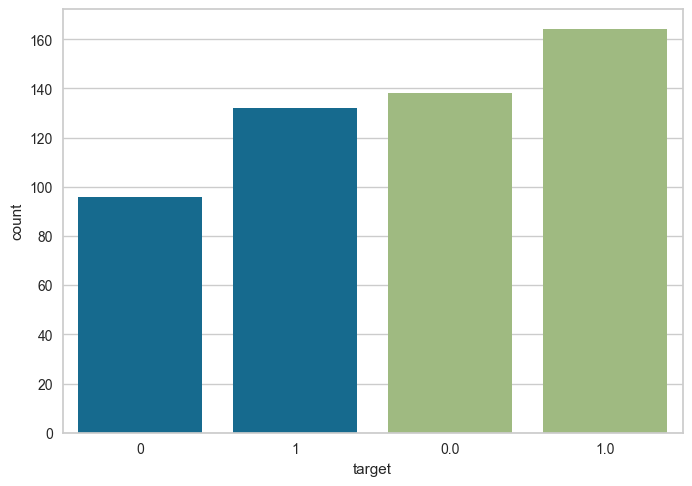

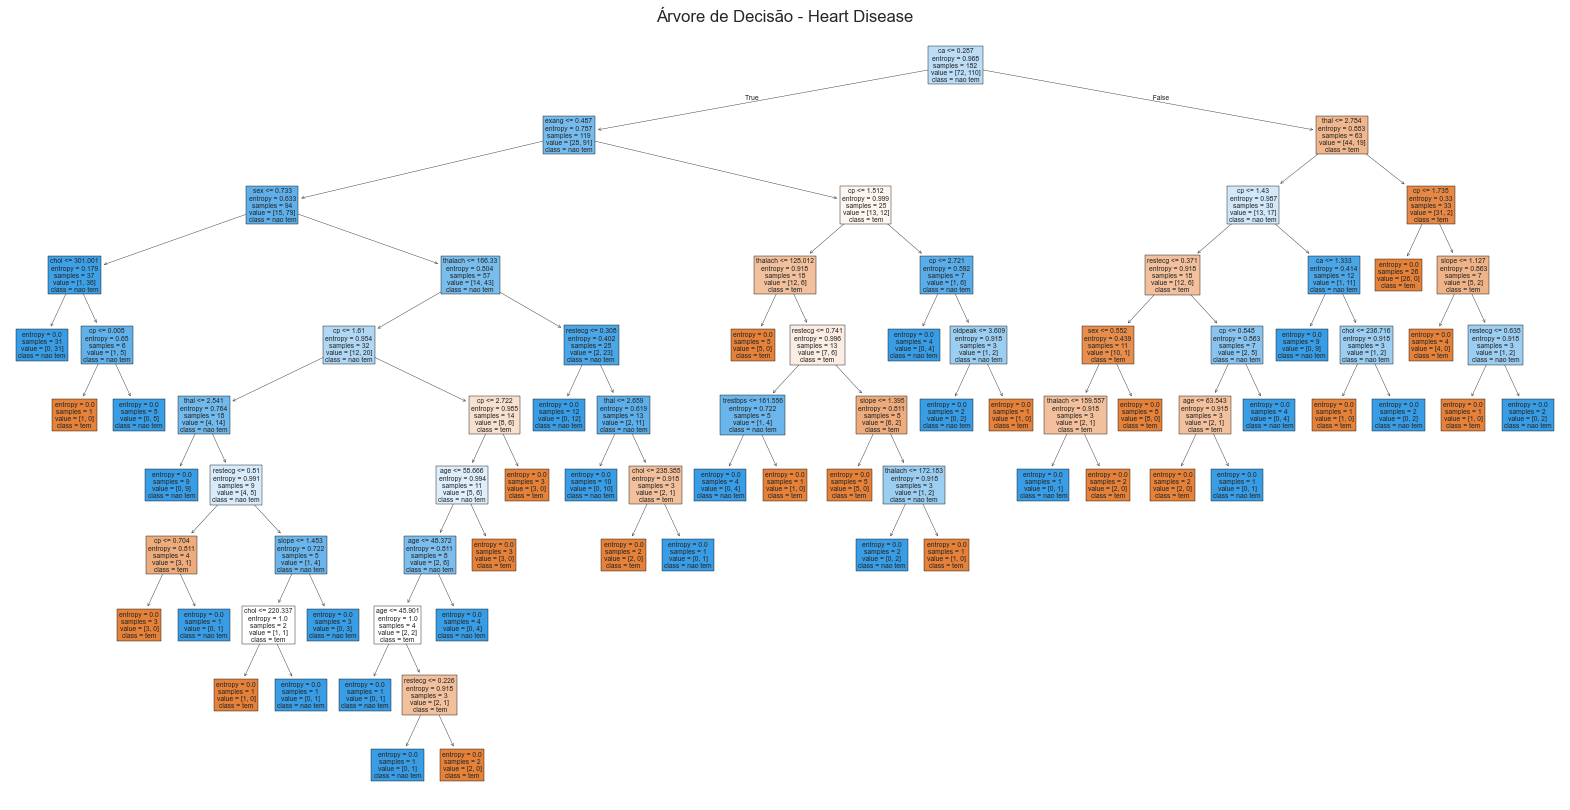

In [1598]:
from sklearn import tree

plt.figure(figsize=(20,10))
tree.plot_tree(modelo, filled=True, feature_names=X.columns, class_names=['tem', 'nao tem'])
plt.title("Árvore de Decisão - Heart Disease")
plt.show()

In [1599]:
confusion_matrix(y_teste_clean, previsoes)

array([[19,  5],
       [ 5, 17]])

In [1600]:
print(classification_report(y_teste_clean, previsoes))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        24
           1       0.77      0.77      0.77        22

    accuracy                           0.78        46
   macro avg       0.78      0.78      0.78        46
weighted avg       0.78      0.78      0.78        46



DataSet com o KNN

In [1601]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
params = {
    'criterion':  ['gini', 'entropy', 'log_loss'],
    'splitter': ['random'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
}

modelo = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=params,
    cv=10,
    n_jobs=5,
    verbose=1,
)

In [1602]:
modelo.fit(x_treino_knn, y_treino_knn)
print(modelo.best_params_)
print(modelo.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'splitter': 'random', 'max_features': 0.6, 'max_depth': None, 'criterion': 'gini'}
1.0


In [1603]:
modelo= DecisionTreeClassifier(**modelo.best_params_)
modelo.fit(x_treino_knn, y_treino_knn)


DecisionTreeClassifier(max_features=0.6, splitter='random')

In [1604]:
X = data_knn.drop('target', axis=1)  # Features
y = data_knn['target']                # Target

In [1605]:
previsoes = modelo.predict(x_teste_knn)
accuracy_score(y_teste_knn,previsoes)

1.0

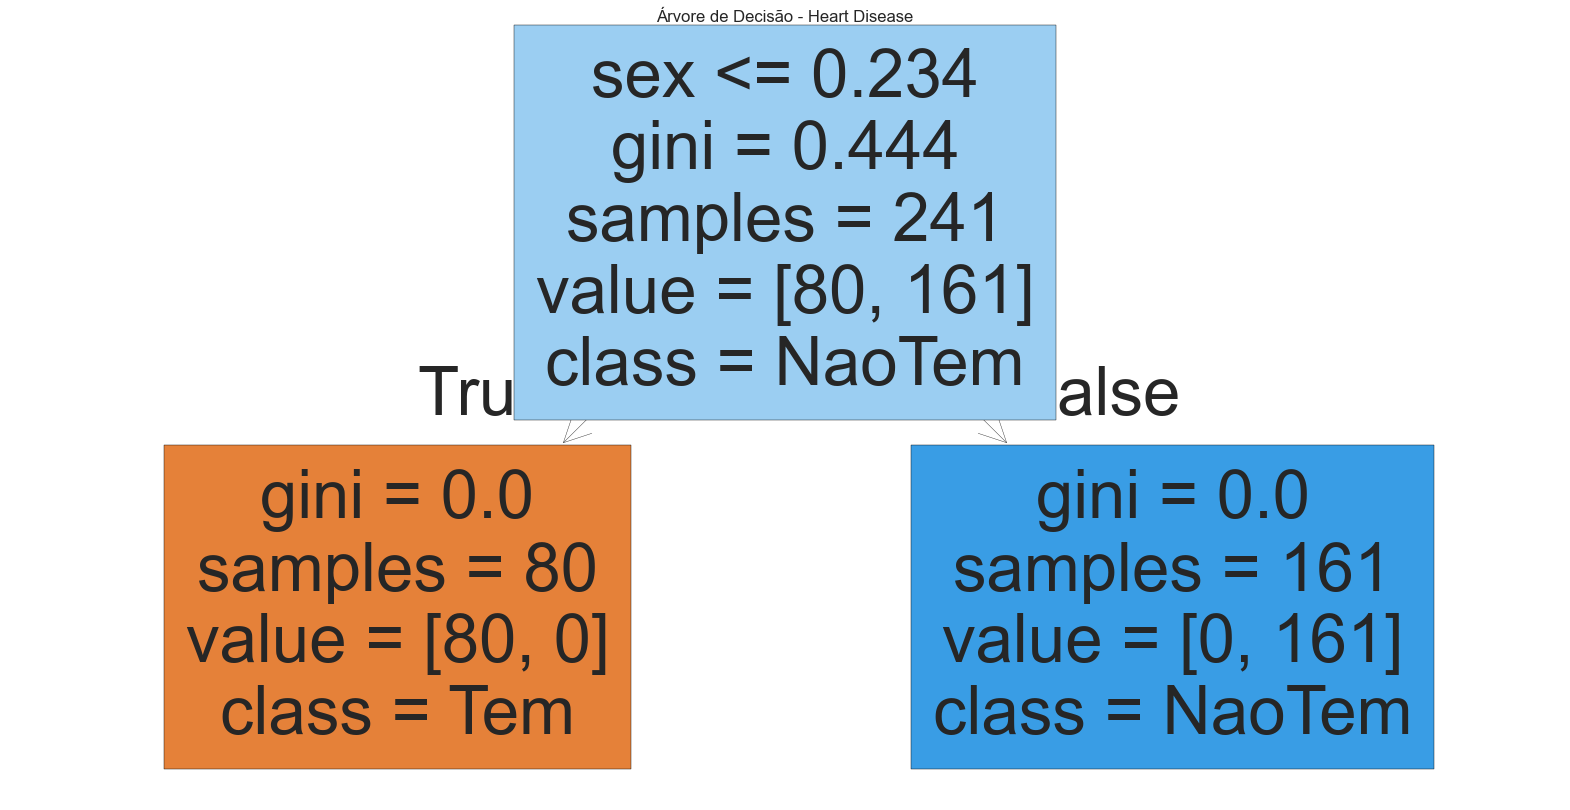

In [1606]:
from sklearn import tree

plt.figure(figsize=(20,10))
tree.plot_tree(modelo, filled=True, feature_names=X.columns, class_names=['Tem', 'NaoTem'])
plt.title("Árvore de Decisão - Heart Disease")
plt.show()

In [1607]:
confusion_matrix(y_teste_knn, previsoes)

array([[16,  0],
       [ 0, 45]])

In [1608]:
print(classification_report(y_teste_knn, previsoes))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00        45

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



**Random Forest**

DataSet com os outliers removidos

In [1609]:
from sklearn.ensemble import RandomForestClassifier
params = {
    'criterion':  ['gini', 'entropy', 'log_loss'],
    'n_estimators': [80,90,95,100],
    'max_features': [None, 'sqrt', 1.5,2,3],
    'random_state' : [None, 21, 42],
}

modelo = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=params,
    cv=10,
    n_jobs=5,
    verbose=1,
)


In [1610]:
modelo.fit(x_treino_clean, y_treino_clean)
print(modelo.best_params_)
print(modelo.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'random_state': 21, 'n_estimators': 100, 'max_features': 'sqrt', 'criterion': 'log_loss'}
0.8456140350877192


c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.p

In [1611]:
modelo= RandomForestClassifier(**modelo.best_params_)
modelo.fit(x_treino_clean, y_treino_clean)

RandomForestClassifier(criterion='log_loss', random_state=21)

In [1612]:
previsoes = modelo.predict(x_teste_clean)
accuracy_score(y_teste_clean,previsoes)

0.8043478260869565

In [1613]:
confusion_matrix(y_teste_clean, previsoes)

array([[21,  3],
       [ 6, 16]])

In [1614]:
print(classification_report(y_teste_clean, previsoes))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82        24
           1       0.84      0.73      0.78        22

    accuracy                           0.80        46
   macro avg       0.81      0.80      0.80        46
weighted avg       0.81      0.80      0.80        46



DataSet com o KNN

In [1615]:
from sklearn.ensemble import RandomForestClassifier
params = {
    'criterion':  ['gini', 'entropy', 'log_loss'],
    'n_estimators': [80,90,95,100],
    'max_features': [None, 'sqrt', 1.5,2,3],
    'random_state' : [None, 21, 42],
}

modelo = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=params,
    cv=10,
    n_jobs=5,
    verbose=1,
)

In [1616]:
modelo.fit(x_treino_knn, y_treino_knn)
print(modelo.best_params_)
print(modelo.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'random_state': 21, 'n_estimators': 95, 'max_features': 'sqrt', 'criterion': 'log_loss'}
1.0


c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.p

In [1617]:
modelo= RandomForestClassifier(**modelo.best_params_)
modelo.fit(x_treino_knn, y_treino_knn)

RandomForestClassifier(criterion='log_loss', n_estimators=95, random_state=21)

In [1618]:
previsoes = modelo.predict(x_teste_knn)
accuracy_score(y_teste_knn,previsoes)

1.0

In [1619]:
confusion_matrix(y_teste_knn, previsoes)

array([[16,  0],
       [ 0, 45]])

In [1620]:
print(classification_report(y_teste_knn, previsoes))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00        45

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61

